# Mortgage Loan Amortisation and Rental Properties

This notebook investigates various case studies involving mortgage bond loan repayments.

In [21]:
import os
import sys
import numpy as np
import pandas as pd
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML

persfin = os.path.join("./","persfin")
sys.path = [persfin]+sys.path

import fingenerators as fingen
import utilityfuns as ufun


# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

## Mortgage Bond Amortisation 

This model and code and code details are shown in the `00-Programming` notebook.

Imagine an account that keeps track of all money flowing in and out on a monthly basis.  The account is iterated on monthly until some end condition is met.  This end condition can be a fixed term or until the bond is repaid (balance is zero).

The main inputs to the model are the following:

1. `principal`: Amount borrowed
1. `interest_rate`: The annual interest rate for this loan.
1. `bondyears`: Bond duration in the number of years for the loan.
1. `reqpayment`: Required payment (minimum) amount per period to repay the loan during the term.
1. `addpayment`: Initial value of additional payments (if any) to be made each period.
1. `addpayrate`: Rate of increase in the  additional payment (can be zero), calculated once per year on January 1.
1. `start_date`: Start date for the loan. The start date is normally 2000-01-01.
1. `cyclesPerAnnum`: Number of payment cycles in a year, normally 12.

Note that the additional payment can be specified as a money value or as a fraction of the required payment. Complex value notation is used where the money value is the real component (e.g., -2300, negative value) and the fractional value is the imaginary component (e.g., .02j, positive fraction). If the (negative) real component (money value) is given the (positive) imaginary component (fraction value) is ignored. For a fractional value of 0.02j the additional payment is 0.02 * `reqpayment`.

The model provides two outputs: a monthly schedule that shows the values for every month as well as a summary of the main values.

The `df` DataFrame provides a monthly view of the account balance, interest, payments, etc.

The `stats` DataFrame provide a summary of the total contract, showing the key values, including the required payment, additional payment (if provided) and the total interest over the full term of the contract.  Note that the principal value is positive (inflow) and the payments and interest are negative (outflow).  

### Simple example

Observe that although the bond is registered for 20 years, the loan is paid back early, because of the small additional payment. In this case the additioal payment stayed the same for the whole term.

In [22]:
# to calculate  a typical bond repayment case with a non-escalating 2% additional payment
principal = 1000000
interest_rate = 0.09
bondyears = 20
cyclesPerAnnum = 12
reqpayment = round(np.pmt(interest_rate/cyclesPerAnnum, bondyears*cyclesPerAnnum, principal), 2)

df, stats = fingen.amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    bondyears=bondyears, 
    reqpayment = reqpayment,
    addpayment = 0.02j,
    cyclesPerAnnum=cyclesPerAnnum, 
    start_date=date(2000, 1,1),
    addpayrate=0.0,
    ID=""
    )

display(HTML(stats.to_frame().head().to_html()))

,0
Principal,1000000
Payoff Date,2018-12-01 00:00:00
Num Payments,228
Interest Rate,0.09
BondYears,20


In [23]:
# to calculate  a typical bond repayment case with a 6% escalating 2% additional payment
principal = 1000000
interest_rate = 0.09
bondyears = 20
cyclesPerAnnum = 12
addpayrate = 0.06

reqpayment = round(np.pmt(interest_rate/cyclesPerAnnum, bondyears*cyclesPerAnnum, principal), 2)

df, stats = fingen.amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    bondyears=bondyears, 
    reqpayment = reqpayment,
    addpayment = 0.02j,
    cyclesPerAnnum=cyclesPerAnnum, 
    start_date=date(2000, 1,1),
    addpayrate=0.06,
    ID=""
    )

display(HTML(stats.to_frame().head().to_html()))

,0
Principal,1000000
Payoff Date,2018-06-01 00:00:00
Num Payments,222
Interest Rate,0.09
BondYears,20


The following table shows the first few and the last few monthly  cycles of the schedule. Note that in the first month 83% of the payment is interest: only 17% of the payment is applied towards reducing the loan amount.  Towards the end of the term the interest reduces to a small percentage.

In [27]:
# to show the first and last few lines of the payment schedule
df['IntPercent'] = 100 * df['Interest'] / df['ReqPayment']
display(HTML(df.round(0).head().to_html()))
display(HTML(df.round(0).tail().to_html()))

,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,Principal,InterestRate,ID,IntPercent
0,1,2000-01-01,1000000.0,-8997.0,-180.0,-7500.0,998323.0,1000000,0.0,,83.0
1,2,2000-02-01,998323.0,-8997.0,-180.0,-7487.0,996633.0,1000000,0.0,,83.0
2,3,2000-03-01,996633.0,-8997.0,-180.0,-7475.0,994931.0,1000000,0.0,,83.0
3,4,2000-04-01,994931.0,-8997.0,-180.0,-7462.0,993215.0,1000000,0.0,,83.0
4,5,2000-05-01,993215.0,-8997.0,-180.0,-7449.0,991487.0,1000000,0.0,,83.0


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,Principal,InterestRate,ID,IntPercent
217,218,2018-02-01,43472.0,-8997.0,-514.0,-326.0,34287.0,1000000,0.0,,4.0
218,219,2018-03-01,34287.0,-8997.0,-514.0,-257.0,25033.0,1000000,0.0,,3.0
219,220,2018-04-01,25033.0,-8997.0,-514.0,-188.0,15710.0,1000000,0.0,,2.0
220,221,2018-05-01,15710.0,-8997.0,-514.0,-118.0,6317.0,1000000,0.0,,1.0
221,222,2018-06-01,6317.0,-6365.0,-0.0,-47.0,0.0,1000000,0.0,,1.0


## Bond Repayment Studies


### Fixed scenario, different additional payments

This calculation shows how the bond/mortgage term can be shortened by adding a fixed percentage (0%, 2%, 10%, 20%, or 30%) to the required payment.  By increasing the payment the term is shortened significantly and the total money paid is much reduced.

In [28]:
scenarios = {
    '0.04%, add=0%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0,'years':20},
    '0.04%, add=2%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.02j,'years':20},
    '0.04%, add=10%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.1j,'years':20},
    '0.04%, add=20%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.2j,'years':20},
    '0.04%, add=30%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.3j,'years':20},
}
        
schedules,stats = ufun.calc_scenarios(scenarios) 

In [30]:
dfstats = pd.DataFrame([stats[key] for key in stats.keys()])
dfstats['Years'] = dfstats['Num Payments'] / 12
dfstats['Additional % payment'] = 100 * dfstats['AddPayment'] / dfstats['ReqPayment']
dfstats['TotalPaid/Principal'] = 1 - dfstats['Total Interest'] / dfstats['Principal']
display(HTML(dfstats.round(2).to_html()))

,Principal,Payoff Date,Num Payments,Interest Rate,BondYears,ReqPayment,AddPayment,Addpayrate,Total Interest,ID,Years,Additional % payment,TotalPaid/Principal
0,1000000,2019-12-01,240,0.09,20,-8997.26,0.00,0,-1159342.10,,20.00,-0.0,2.16
1,1000000,2018-12-01,228,0.09,20,-8997.26,-179.95,0,-1087467.23,,19.00,2.0,2.09
2,1000000,2015-10-01,190,0.09,20,-8997.26,-899.73,0,-878228.77,,15.83,10.0,1.88
3,1000000,2013-03-01,159,0.09,20,-8997.26,-1799.45,0,-714178.37,,13.25,20.0,1.71
4,1000000,2011-06-01,138,0.09,20,-8997.26,-2699.18,0,-604582.36,,11.50,30.0,1.60


Notice how the term of the contract dramatically shortens if a fixed additional payment is made. If you pay 30% extra over and above the required payment, the term shortens from 20 years to just under 12 years.

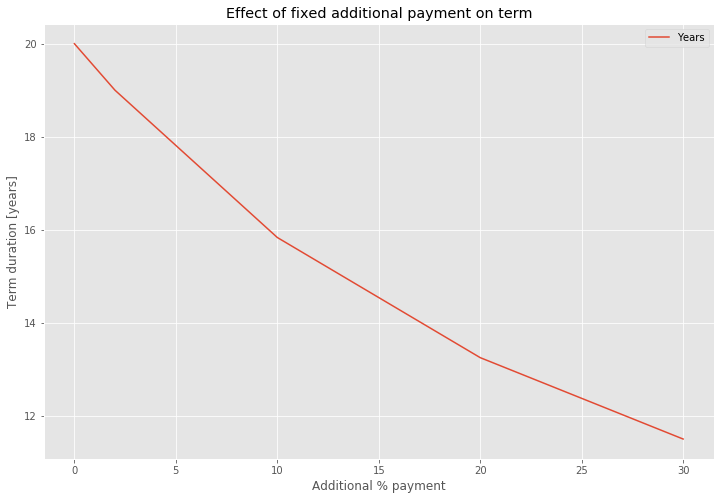

In [7]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='Years', ax=ax)
plt.title("Effect of fixed additional payment on term");
plt.ylabel("Term duration [years]");


The next graph shows the total money repaid on the contract as a function of additional payment.  

If no additional payment is made, the total amount paid back over the full term of the contract is 2.16 times the initial loan principal amount.

Notice how the interest dramatically reduces if a fixed additional payment is made. 
If you pay 30% extra over and above the required payment, the total amount paid back over the full term of the contract is 1.6 times the initial loan principal amount.

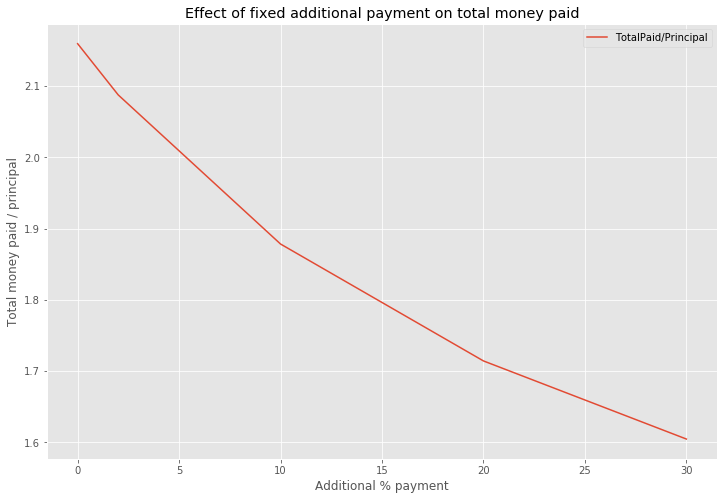

In [8]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='TotalPaid/Principal', ax=ax)
plt.title("Effect of fixed additional payment on total money paid");
plt.ylabel("Total money paid / principal");


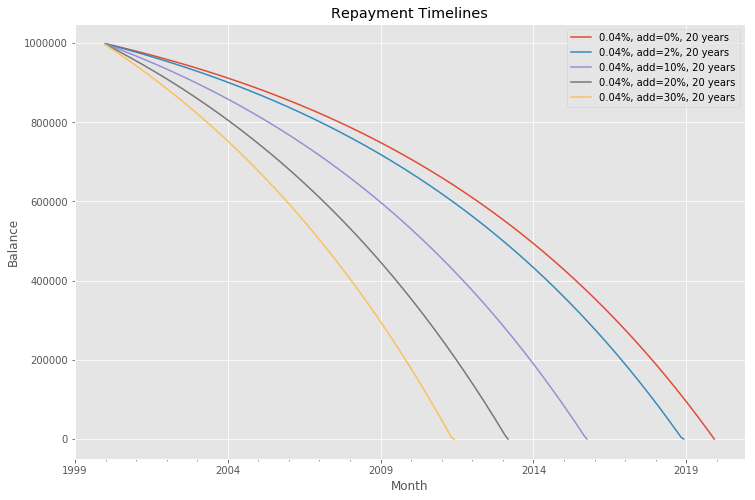

In [9]:
ufun.plot_amort_balance(schedules,scenarios)

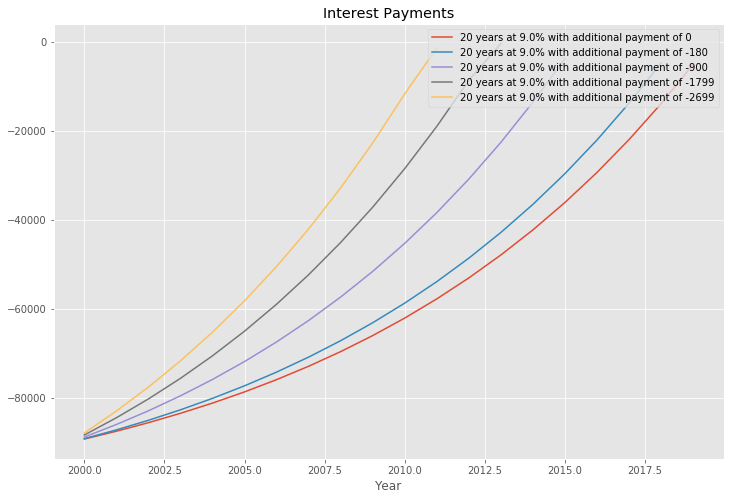

In [10]:
ufun.plot_amort_annual_interest(schedules,scenarios, stats)   

## Tax savings vs loan duration

Is it worth borrowing money for an investment property with the objective of writing interest off against tax?
It would seem to make sense to invest some cash and then take out a bond to cover the remainder of the purchase price.
The rent is an income and hence is taxable, however the bond interest is an expense and must be subtracted from the rent income before tax.
So in principle, it seems like a good idea to take out a bond and get the tax benefit on the interest.  In effect the tax man pays a portion of the interest.

This model increases the rent from a starting value only once per year.

Observe the effect of the number of years from 5 to 20, and the effect of changing the tax rate.

This analysis presently ignores the effect of time value of money.  



In [11]:
# bond values
principal = 500000
interest_rate = 0.09

# tax rate and rental income 
rentpmonth = 4500
increasepyear = 0.06

# experiment with variations
dfSch = pd.DataFrame()
dfSum = pd.DataFrame()

for bondyears in [4,5,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,nistats = ufun.bondtaxsavingsanalysis(principal=principal,
                            interest_rate=interest_rate,bondyears=bondyears,
                            taxrate=taxrate,rentpmonth=rentpmonth,
                            increasepyear=increasepyear)
        # append all cases in to single df, must be filtered later
        dfSch = dfSch.append(dfc)
        # append all summaries into single df
        dfSum = dfSum.append(nistats,ignore_index=True)

The `dfSch` data frame contains all the month's status' for all the scenarios in one data frame.  To plot or analyse you must apply a filter to select only the required `NumPay` and `TaxRate` values.

In [36]:
display(HTML(dfSch.drop(['Month','Principal','InterestRate'],axis=1).round(2).head().to_html()))
display(HTML(dfSch.drop(['Month','Principal','InterestRate'],axis=1).round(2).tail().to_html()))

,Period,Interest,End Balance,ID,Rent,NumPay,TaxRate,TaxNoInter,IncomeNoInter,TaxWithInter,IncomeWithInter,BondBenefit
0,1,-3750.00,491307.48,,4500.0,49,0.2,-900.0,3600.0,-150.00,4350.00,750.00
1,2,-3684.81,482549.77,,4500.0,49,0.2,-900.0,3600.0,-163.04,4336.96,736.96
2,3,-3619.12,473726.37,,4500.0,49,0.2,-900.0,3600.0,-176.18,4323.82,723.82
3,4,-3552.95,464836.80,,4500.0,49,0.2,-900.0,3600.0,-189.41,4310.59,710.59
4,5,-3486.28,455880.56,,4500.0,49,0.2,-900.0,3600.0,-202.74,4297.26,697.26


,Period,Interest,End Balance,ID,Rent,NumPay,TaxRate,TaxNoInter,IncomeNoInter,TaxWithInter,IncomeWithInter,BondBenefit
235,236,-164.97,17661.78,,13615.2,240,0.42,-5718.38,7896.81,-5649.10,7966.10,69.29
236,237,-132.46,13295.61,,13615.2,240,0.42,-5718.38,7896.81,-5662.75,7952.45,55.63
237,238,-99.72,8896.70,,13615.2,240,0.42,-5718.38,7896.81,-5676.50,7938.70,41.88
238,239,-66.73,4464.80,,13615.2,240,0.42,-5718.38,7896.81,-5690.36,7924.84,28.03
239,240,-33.49,0.00,,13615.2,240,0.42,-5718.38,7896.81,-5704.32,7910.88,14.07


The following table shows the savings (BondBenefit) by claiming the interest back from tax:

In [19]:
# to compare different bond and tax rate scenarios
drops = ['AddPayment','Bond','IncomeNoInter','IncomeWithInter',
         'InitRent','ReqPayment','TaxNoInter','TaxWithInter','Total Rent','Interest Rate']
df = dfSum.drop(drops,axis=1)
df = df[['Num Payments','TaxRate','BondBenefit','Benefit/Rent %']]
# display(HTML(df.to_html(index=False)))
dfp = pd.pivot_table(df, index=['Num Payments'],values=['BondBenefit'],columns=['TaxRate'])
display(HTML(dfp.round(0).to_html(index=True)))

It seems that for bond periods of around 4 to 5 years, the savings benefit is only significant at high tax rates: the cost of setting up the bond may consume a substantial portion of the actual savings. As expected, at higher tax rates the income benefit is more. The savings expressed as percentage of rental income before tax and interest is not very high.

However, this calculation is not completely accurate:
1. To repay the bond over five years you need to pay a significant additional amount. There is a cost to this additional payment not accounted for this simple calculation.
1. The time value of money is not included here.

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [ ]:
# to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark
# conda install -c conda-forge watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy -g 